In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils.DataSplitter
import utils.Pytorch
from utils.tools import plotFitAndPredictions, plotLossCurves
from utils.metrics import *

In [2]:
# Change accordingly
diff = False
lags = [1, 4, 8, 20, 40, 120, 140]  # [i+1 for i in range(20)] + [40, 60, 80, 100, 120, 140]  # <-- To use all columns
exog = True

if diff:
    # Input diff, output diff
    target_column = "diff"
    drop_cols = ["date", "hour", "year", "quarter", "Q1", "month",
                 "monthNumber", "weekNumber", "weekDay", "dateNumber", "mon",
                 "workdayPlan", "line", "passengersBoarding", "datetime", "eventName"]
    lagColName = "diffLag"
    
if not diff:
    # Input passengers, output passengers
    target_column = "passengersBoarding"
    drop_cols = ["date", "hour", "year", "quarter", "Q1", "month",
                 "monthNumber", "weekNumber", "weekDay", "dateNumber", "mon",
                 "workdayPlan", "line", "datetime", "eventName"]
    lagColName = "lag"

true_target_column = "passengersBoarding"
df60 = utils.DataSplitter.getTrainData(60, diff=diff)

train60, val60 = utils.DataSplitter.performTrainValSplit(df60)
train60_1A = train60[train60["line"] == "1A"].reset_index(drop=True)
val60_1A = val60[val60["line"] == "1A"].reset_index(drop=True)
val60_1A.index += train60_1A.index.stop

X_train = train60_1A.drop(columns=([target_column] + drop_cols), axis=1).reset_index(drop=True)
X_val = val60_1A.drop(columns=([target_column] + drop_cols), axis=1).reset_index(drop=True)
y_train = train60_1A[target_column].reset_index(drop=True)
y_val = val60_1A[target_column].reset_index(drop=True)
y_train_true = train60_1A[true_target_column].reset_index(drop=True)
y_val_true = val60_1A[true_target_column].reset_index(drop=True)
y_val_true.index += y_train.index.stop

X_train, X_val = utils.Pytorch.selectFeatures(X_train, X_val, lags=lags, exog=exog, lagColName=lagColName)

In [3]:
if torch.cuda.is_available():
    print("cuda")
    device = torch.device("cuda")
else:
    print("cpu")
    device = torch.device("cpu")

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=5, num_layers=2, output_size=1, dropout_prob=0.1, bidirectional=True):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

cuda


In [4]:
model = LSTM(hidden_size=100, num_layers=2, dropout_prob=0.35, bidirectional=True)
model, y_train_pred, y_val_pred, epoch_range, train_loss_list, val_loss_list = utils.Pytorch.forecastPytorch(utils.Pytorch.fixedWindowPytorch,
                                                                                                             X_train,
                                                                                                             y_train,
                                                                                                             X_val,
                                                                                                             y_val,
                                                                                                             y_train_true,
                                                                                                             y_val_true,
                                                                                                             model=model,
                                                                                                             batchSize=32,
                                                                                                             epochs=40,
                                                                                                             lr=1e-3,
                                                                                                             device=device,
                                                                                                             lagColName=lagColName,
                                                                                                             horizon=40)

Forecast iteration: 46


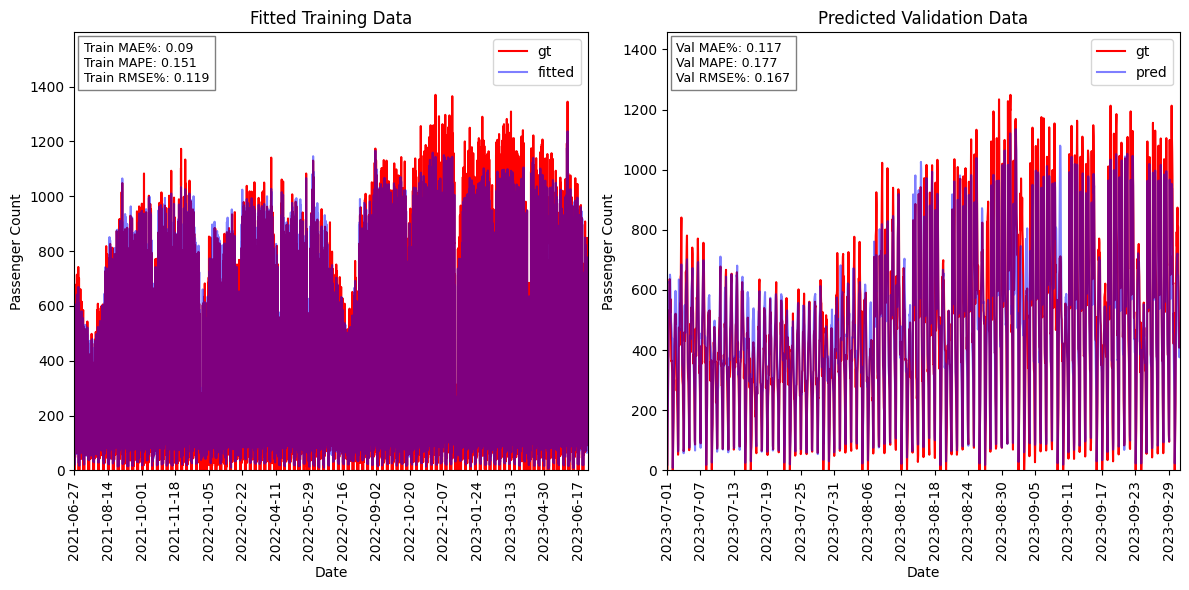

In [5]:
plotFitAndPredictions(y_train_pred, y_val_pred, y_train_true, y_val_true, trainDateCol=train60_1A["date"], valDateCol=val60_1A["date"])

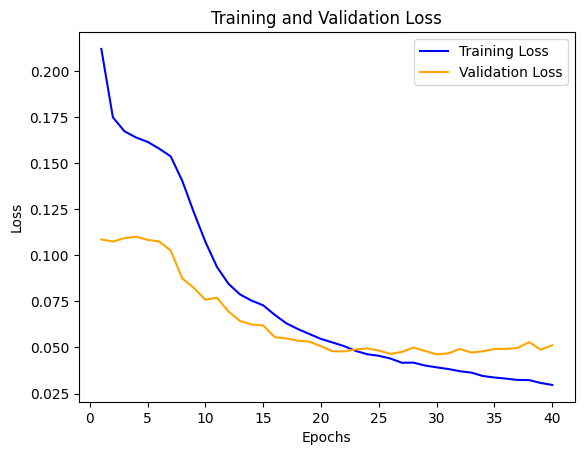

In [6]:
plotLossCurves(train_loss_list, val_loss_list, epoch_range)

## lr = 10^-3, hidden_size = 50, n_layers = 4

### Batch gradient descent (100 epochs)
MAE: 1158.678

RMSE: 1559.774

Train loss: 0.3219127655029297

Validation loss: 0.29513391852378845

### Batch size = 1468 / 10 batches (100 epochs)
MAE: 800.15

RMSE: 1069.872

Train loss: 0.13537027463316917

Validation Loss: 0.14593974500894547

### Batch size = 978 / 15 batches (100 epochs)
MAE: 792.168

RMSE: 1059.725

Train loss: 0.13312541443156078

Validation Loss: 0.1379912607371807

### Batch size = 734 / 20 batches (100 epochs)
MAE: 792.649

RMSE: 1044.83

Train loss: 0.11595435291528702

Validation Loss: 0.1367316817243894

### Batch size = 489 / 30 batches (100 epochs)
MAE: 815.339

RMSE: 1095.619

Train loss: 0.12239421086926613

Validation Loss: 0.14689216017723083

### Batch size = 32 (100 epochs)
MAE: 864.641

RMSE: 1151.149

Train loss: 0.04935611497553995

Validation Loss: 0.16076639365276385

## lr = 10^-3, hidden_size = 50, n_layers = 4

### Batch size = 978 / 15 batches (100 epochs)
MAE: 796.149

RMSE: 1072.83

Train Loss: 0.11068850380252115

Validation Loss: 0.14133882895112038

### Batch size = 734 / 20 batches (100 epochs)
MAE: 801.216

RMSE: 1067.93

Train loss: 0.10946012996137142

Validation Loss: 0.13967678447564444

# Method

- Implemented LSTM with Adam optimizer, lr=10^-3, hidden_size=50, n_layers=2

- Implemented the ability to take minibatches and then tried hidden_size=100&n_layers=2, hidden_size=50&n_layers=4 and hidden_size=100&n_layers=4

- Implemented dropout as regularization, since it was overfitting on smaller batchsizes

- Implemented bi-directional LSTM